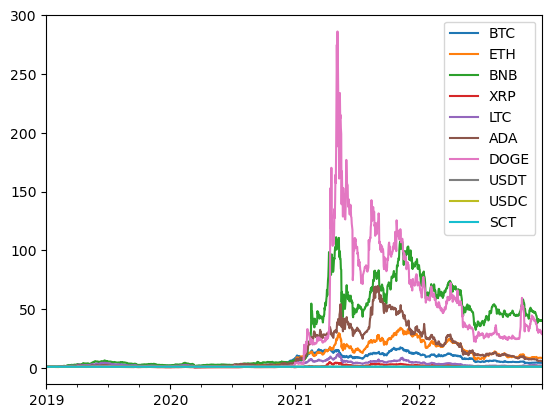

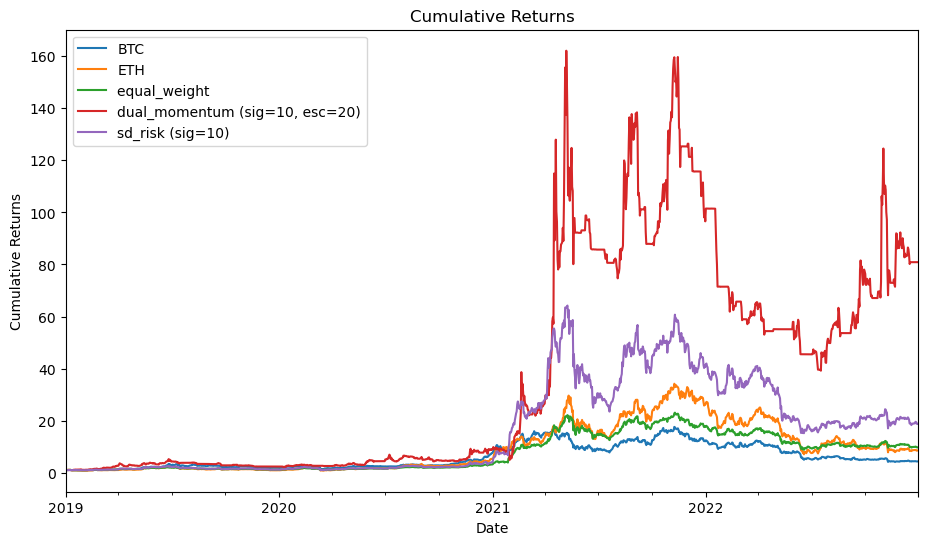

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from traders_class import FixedWeightTrading, MomentumTrading, RiskParityTrading
%matplotlib inline


def data_reading(crypto_name):
    with open('crypto_data.json', 'r') as f:
        data_json = f.read()
    data_dict = json.loads(data_json)
    return data_dict[crypto_name]['data']

def transform(input_data):
    output_data = [1.0]*len(input_data)
    for i in range(len(input_data)):
        if i != 0:
            fraction = input_data[i]/input_data[i-1]
            output_data[i] = output_data[i-1]*fraction
    return output_data


def plot_performance(traders, strategy_list, df_returns, benchmark_label=['BTC','ETH'], Returns='Returns'):
    # Plot cumulative returns
    fig, ax = plt.subplots(figsize = (11, 6))
    
    (1+df_returns[benchmark_label]).cumprod().plot(ax=ax, label=benchmark_label)
    for i, strategy in enumerate(strategy_list):
        (1+strategy[Returns]).cumprod().plot(ax=ax, label= f'{traders[i][1]} {traders[i][2]}')
    
    ax.set_title('Cumulative Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.legend()
    plt.show()
    return None

if __name__ == '__main__':
    currencies = ["BTC", "ETH", "BNB", "XRP", "LTC", 'ADA', "DOGE", "USDT", "USDC"]
    dates = pd.to_datetime(pd.date_range("20190101", periods=1461))
    data_array = np.empty((len(dates), len(currencies)))
    for i, coin in enumerate(currencies):
        data = data_reading(coin)
        data_array[:, i] = data
    
    df = pd.DataFrame(data_array, index=dates, columns=currencies)
    df['SCT'] = [1] * df.shape[0]
    df_returns = df.pct_change()
    (1+df_returns).cumprod().plot()
    df_normalized = df / df.iloc[0]

    
    traders = [
        (FixedWeightTrading(df.copy(), df_returns.copy(), ''), 'equal_weight', ''),
        (MomentumTrading(df.copy(), df_returns.copy(), 10, 20, None), 'dual_momentum', '(sig=10, esc=20)'),
        (RiskParityTrading(df.copy(), df_returns.copy(), df_normalized.copy(), 10), 'sd_risk', '(sig=10)'),
    ]
    traders_portfolio = [pd.DataFrame(np.nan, index=df.index, columns=df.columns.append(pd.Index(['Returns']))) for _ in range(len(traders))]
    #scam = [0] * df.shape[0]

    
    
    for t in range(0, df.shape[0]-1):
        for i, (q, method_name, _) in enumerate(traders):
            traders_portfolio[i].iloc[t, :-1] = getattr(q, method_name)(t)
            traders_portfolio[i]['Returns'][t+1] = np.sum(traders_portfolio[i].iloc[t, :-1] * df_returns.iloc[t+1, :-1])
            #scam[t+1] += traders_portfolio[i].iloc[t, df.columns.get_loc('SCT')] * df_returns.iloc[t+1, df.columns.get_loc('SCT')]
    
    plot_performance(traders, traders_portfolio, df_returns.copy())